In [1]:
import numpy as np
import astropy.constants as c
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.units import cds
cds.enable()
import pandas as pd

# Part 1
## 1A: Collecting necessary data and functions

In [2]:
latitude = -30.24463 * u.deg
longitude = -70.74942 * u.deg
altitude = 2647 * u.m
p0 = 101325.0 * u.Pa
g = c.g0 #9.80665 * u.m / u.s**2
R0 = c.R
T0 = 19. * u.deg_C
lapserate = -6.5 * u.deg_C / u.km
M = 0.0289644 * u.km/u.mol

In [3]:
# Temperature and pressure calculations
temperature = T0 + (lapserate * altitude)
temperatureK = temperature.to(u.K, equivalencies=u.temperature())
exponent = (-(g * M * altitude)/(R0 * temperatureK)).value
Pressure = (p0 * np.exp(exponent)).to(u.Pa)
humidity = 40.

In [4]:
# Air pressure and Vapor Pressure
def calcpw(RH, tin):
    t = tin.value
    x = np.log(RH/100)
    td = (238.3 * (((t + 238.3)*x + (17.2694*t)) / ((t+238.3)*(17.2694 - x) - (17.2694 * t))))
    pw = (4.50874 + (0.341724 * td**2) + (0.184889*10**-3 * td**3) + (0.238294*10**-5 * td**4) + (0.203447*10**-7 * td**5)) * u.cds.mmHg
    return pw
Pw = calcpw(humidity, temperature).to(u.cds.mbar)
T = temperatureK
Ps = Pressure.to(u.cds.mbar) # Dry air pressure in millibars

In [5]:
# calculating n with given variables
def calcindex(wavelength, Ps_in, Tinitial, Pw_in):
    T = Tinitial.to(u.K, equivalencies = u.temperature()).value
    Ps = 1.333224 * (Ps_in.to(u.Pa).value - Pw_in.to(u.Pa).value)
    Pw = 1.333224 * Pw_in.to(u.Pa).value
    sigma = 1/wavelength.to(u.um).value
    Ds = (1 + (Ps * (57.90e-8 - (9.3250e-4/T) + (0.25844/T**2)))) * (Ps/T)
    Dw = (1 + Pw * (1 + 3.7e-4 * Pw) * (-2.37321e-3 + ((2.23366/T)-(710.792/T**2) + (7.75141e4/T**3)))) * (Pw/T)
    term_one = (2371.34 + (683939.7/(130 - sigma**2)) + (4547.3/(38.9 - sigma**2))) * Ds
    term_two = ((6487.31 + (58.058 * sigma**2) - (0.71150 * sigma**4) + (0.08851 * sigma**6))) * Dw
    n = ((term_one + term_two) / (1e8))
    return n

def calcBeta(Tin):
    beta = 0.001254 * ((Tin.to(u.K, equivalencies = u.temperature()).value)/273.15)
    return beta

# will define kappa function here but will set kappa=1 for our purposes
def calcKappa(phideg, height):
    phi = (phideg.to(u.rad)).value
    kappa = 1 + 0.005302*np.sin(phi)**2 - 0.00000583*np.sin(2*phi)**2 - 0.000000315*height.value
    return kappa

# using above functions, we can calculate refraction
def calcRefrac(wavelength, PS_in, PW_in, Tinitial, z0):
    gamma = calcindex(wavelength, PS_in, Tinitial, PW_in)
    beta = calcBeta(Tinitial.to(u.K, equivalencies = u.temperature()))
    kappa = 1
    refraction = (kappa * gamma * (1 - beta) * np.tan(z0.to(u.rad))) - (kappa * gamma * (beta - (gamma / 2)) * (np.tan(z0.to(u.rad))**3))
    
    return refraction

In [6]:
# defining g- and i-bands in wavelength and throughput from throughput data
gband = pd.read_csv('throughputs/baseline/total_g.dat', sep=' ', header=7)
gband.columns = ['Wavelength','Throughput']
gWavelength = np.array(gband['Wavelength'][0:7755]) * u.nm
gThroughput = np.array(gband['Throughput'][0:7755])

iband = pd.read_csv('throughputs/baseline/total_i.dat', sep=' ', header=7)
iband.columns = ['Wavelength', 'Throughput']
iWavelength = np.array(iband['Wavelength'][0:7755]) * u.nm
iThroughput = np.array(iband['Throughput'][0:7755])

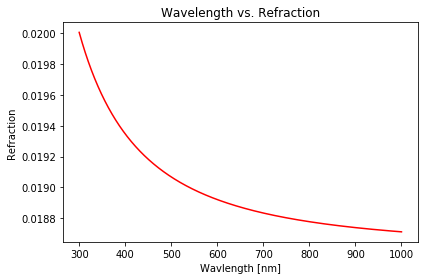

In [7]:
# defining input zenith angle, wavelength range to work in
wavelengths = np.linspace(300, 1000, 7755) * u.nm
Zin = 30 * u.deg

# checking refraction calculations 
N = calcindex(wavelengths, Ps, temperatureK, Pw)
B = calcBeta(temperatureK)
R = calcRefrac(wavelengths, Ps, Pw, temperatureK, Zin)

# plotting refraction calculations
gmin = 386.30*u.nm
gmax = 567.00*u.nm
imin = 675.90*u.nm
imax = 833.00*u.nm

# calcplotALL(temperature, Ps, Pw, wavelengths, Zin, Pressure, minwl=300*u.nm, maxwl=1000*u.nm)
fig, ax = plt.subplots(1,1)
plt.plot(wavelengths, R, color='r')
ax.set_title('Wavelength vs. Refraction')
ax.set_xlabel('Wavlength [nm]')
ax.set_ylabel('Refraction')
plt.tight_layout()
plt.show()
### check omega factor being applied twice etc.
### refraction needs to return in units of arcsec or other angular unit

In [8]:
Zin = 30*u.deg
N1 = calcindex(500*u.nm, Ps, temperatureK, Pw)
N2 = calcindex(450*u.nm, Ps, temperatureK, Pw)
B = calcBeta(temperatureK)
R1 = calcRefrac(500*u.nm, Ps, Pw, temperature, Zin)
R2 = calcRefrac(450*u.nm, Ps, Pw, temperature, Zin)
print(R2-R1)
print((R2-R1) * (180/np.pi) * 3600)
### r2 - r1 should be on scale of 0.2-2.0

0.00011487896531633957
23.695487522841685


## 1B: Plot simulated Quasar Spectra

In [9]:
Qdata = pd.read_csv('QuasarData.txt', sep=' ', header = None, skipinitialspace=True)
Qdata.columns = ['Wavelength','FluxDensity','eFluxD']
print(Qdata)
Wavelength = (np.array(Qdata['Wavelength'])*u.Angstrom).to(u.nm)
FluxD = np.array(Qdata['FluxDensity'])

      Wavelength  FluxDensity  eFluxD
0          800.5        0.149   0.074
1          801.5        0.000   0.260
2          802.5        0.676   0.227
3          803.5        0.000   0.222
4          804.5        0.413   0.159
...          ...          ...     ...
7750      8550.5        0.733   0.056
7751      8551.5        0.723   0.049
7752      8552.5        0.718   0.054
7753      8553.5        0.776   0.046
7754      8554.5        0.792   0.065

[7755 rows x 3 columns]


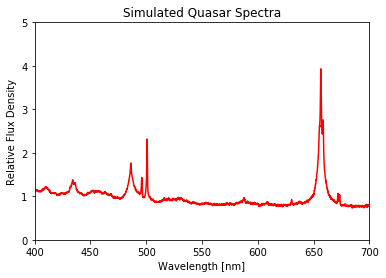

In [10]:
# plotting simulated quasar spectra from imported data above
fig, ax = plt.subplots(1,1)
plt.plot(Wavelength, FluxD, color='r')
plt.title('Simulated Quasar Spectra')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Relative Flux Density')
ax.set_xlim(400,700)
ax.set_ylim(0,5)

plt.show()

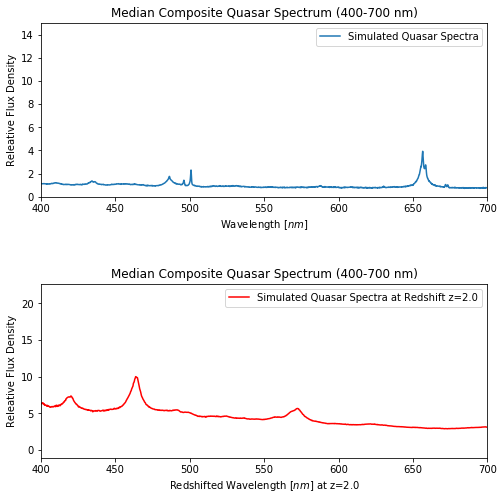

In [11]:
# Problem 1b
# Wavlengths = 400-700   ---- these are any wavelengths in table from 4000-7000
# create function that defines the observed wavelength based on emitted wavelength input at redshift of 0 and new redshift
def redshiftchange(zval, emit):
    observed = (1+zval) * (emit)
    return observed

z = 2.0  # set redshift to plot wavelengths observed at that redshift

# plot data only between (400 to 700)
redshiftedW = redshiftchange(z, Wavelength)


fig, ax = plt.subplots(2,1, figsize=(8,8))
ax0 = ax[0].plot(Wavelength, FluxD, label='Simulated Quasar Spectra')
ax[0].set_title('Median Composite Quasar Spectrum (400-700 nm)')
ax[0].set_xlabel('Wavelength $[nm]$')
ax[0].set_ylabel('Releative Flux Density')
ax[0].set_aspect('auto')
ax[0].set_xlim(400,700)
ax[0].set_ylim(0,15)
ax[0].legend(loc='best')

# plot at varying redshifts
ax1 = ax[1].plot(redshiftedW, FluxD, label=f'Simulated Quasar Spectra at Redshift z={z}', c='r')
ax[1].set_title('Median Composite Quasar Spectrum (400-700 nm)')
ax[1].set_xlabel(f'Redshifted Wavelength $[nm]$ at z={z}')
ax[1].set_ylabel('Releative Flux Density')
ax[1].legend(loc='best')
ax[1].set_aspect('auto')
ax[1].set_xlim(400,700)
ax[0].set_ylim(0,15)
fig.subplots_adjust(hspace=0.5)
plt.show()

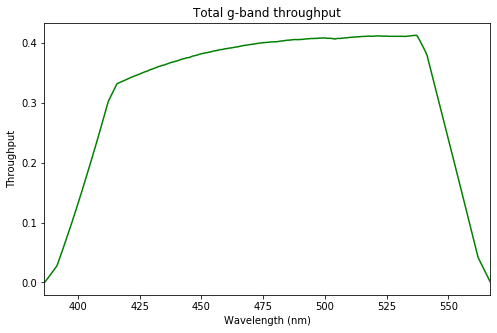

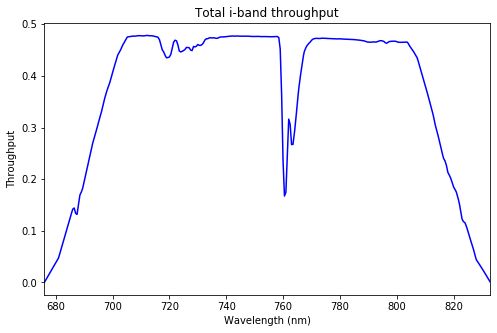

In [12]:
def pltthroughput(wavelength, thru, filterband, units=u.nm, minwl=None, 
                  maxwl=None, logscale=False, color=None):
    fig, ax = plt.subplots(figsize=(8,5))
    wavenm = wavelength.to(units)
    plt.plot(wavenm, thru, color=color)
    wl_min = minwl if minwl is not None else np.min(wavelength)
    wl_max = maxwl if maxwl is not None else np.max(wavelength)
    ax.set_xlim(wl_min.value, wl_max.value)
    plt.title(f'Total {filterband}-band throughput')
    plt.xlabel(f'Wavelength ({units})')
    plt.ylabel('Throughput')
    if logscale is True:
        ax.set_yscale('log')
        
pltthroughput(gWavelength, gThroughput, 'g', minwl=386.30*u.nm, maxwl=567.0*u.nm, 
              color='g')
pltthroughput(iWavelength, iThroughput, 'i', minwl=675.90*u.nm, maxwl=833.0*u.nm, 
              color='b')

# Part 2
## 2A: Computing simulated quasar spectra as observed through LSST bandpasses

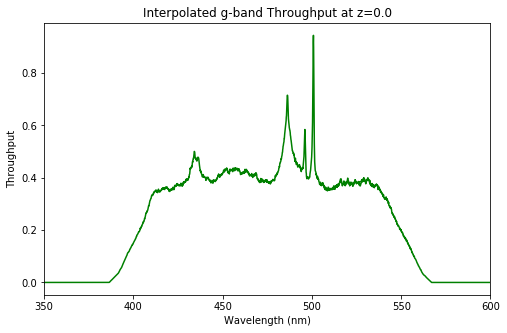

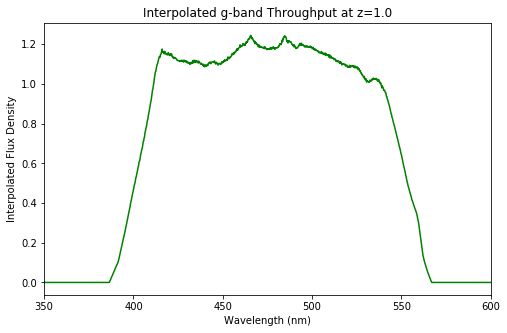

In [13]:
gInterp = np.interp(Wavelength, gWavelength, gThroughput)
pltthroughput(Wavelength, FluxD * gInterp, 'g', minwl=350*u.nm, maxwl=600*u.nm, 
              color='g')
plt.title('Interpolated g-band Throughput at z=0.0')

# creating redshifted wavelengths to plot interpolated spectra at various redshifts
wavez1 = redshiftchange(1, Wavelength)
wavez15 = redshiftchange(1.5, Wavelength)
wavez2 = redshiftchange(2, Wavelength)
wavez25 = redshiftchange(2.5, Wavelength)

# Plotting redshifted wavelengths vs interpolated flux density at given redshift
zIN = 1.0
gInterpz1 = np.interp(wavez1, gWavelength, gThroughput)
pltthroughput(wavez1, FluxD*gInterpz1, 'g', minwl=350*u.nm,maxwl=600*u.nm,
             color='g')
plt.title(f'Interpolated g-band Throughput at z={zIN}'); plt.ylabel('Interpolated Flux Density')
plt.show()

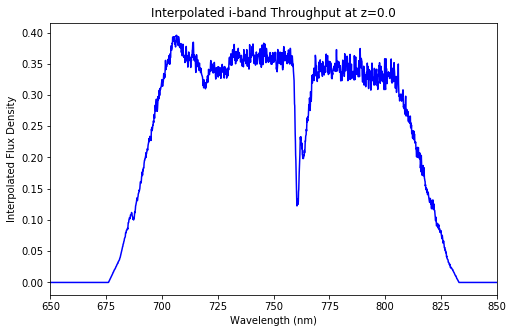

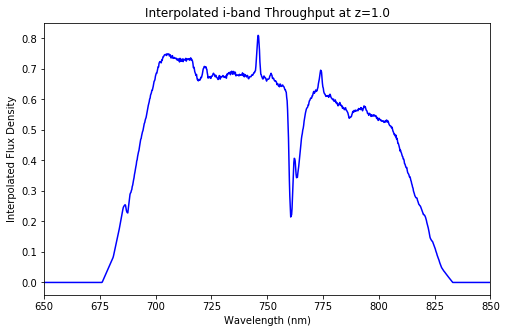

In [14]:
# now plotting using i-band
iInterp = np.interp(Wavelength, iWavelength, iThroughput)
pltthroughput(Wavelength, FluxD * iInterp, 'i', minwl=650*u.nm, maxwl=850*u.nm,
             color='b')
plt.title('Interpolated i-band Throughput at z=0.0');
plt.ylabel('Interpolated Flux Density')

# creating interpolation for i-band at given wavelengths
iInterpz1 = np.interp(wavez1, iWavelength, iThroughput)

# plotting the i-band interpolation
pltthroughput(wavez1, FluxD*iInterpz1, 'g', minwl=650*u.nm,maxwl=850*u.nm,
             color='b')
plt.title(f'Interpolated i-band Throughput at z={zIN}'); 
plt.ylabel('Interpolated Flux Density')
plt.show()

## 2B: Defining and Implementing Sub-Bands
- creating following sub-bands based on above plotting exercises for both g-band and i-band independently, such that each sub-band's observed flux density is equal to the others of the same band
    - g-band
        - 370-453nm
        - 453-499nm
        - 499-570nm
    - i-band:
        - 670-731nm
        - 731-774nm
        - 774-840nm

In [15]:
# defining function to calculate flux for sub-bands
def FluxCalc(wavelength, flux, throughput_wl, throughput, band, units=u.nm, redshift=0., wavelength_min=None, wavelength_max=None):
    wlshift = wavelength.to(units) * (1 + redshift)
    thruwl = throughput_wl.to(units)
    interp = np.interp(wlshift, thruwl, throughput)
    wl_min = wavelength_min if wavelength_min is not None else np.min(wlshift)
    wl_max = wavelength_max if wavelength_max is not None else np.max(wlshift)
    flux_obs = flux*interp
    indexs = np.where(np.logical_and(wlshift.value < wl_max.value, wlshift.value > wl_min.value))
    tot_flux = np.sum(flux_obs[indexs])
    wl_stp = wlshift[1] - wlshift[0]
    return (tot_flux*wl_stp).value


In [16]:
# defining sub-band linspaces for g- and i- bands
gsub1 = np.linspace(370, 453, 453-369)* u.nm
gsub2 = np.linspace(453, 499, 499-452)* u.nm
gsub3 = np.linspace(499, 570, 570-498)* u.nm

isub1 = np.linspace(670, 732, 732-669)* u.nm
isub2 = np.linspace(732, 775, 775-731)* u.nm
isub3 = np.linspace(775, 840, 840-774)* u.nm
### tune subbands so that a flat spectra returns three equal values for each defined sub-band

In [17]:
# using the sub-bands individually, we now want total calculated flux within each sub-band
for z in [0]:
    gflux1 = FluxCalc(Wavelength, FluxD, gWavelength, gThroughput, band = 'g', redshift = z, wavelength_min = 370*u.nm, wavelength_max = 453*u.nm)
    print(f'g-band (sub-band 1) total flux at redshift z = {z} is {gflux1:.2f}')
    gflux2 = FluxCalc(Wavelength, FluxD, gWavelength, gThroughput, band = 'g', redshift = z, wavelength_min = 453*u.nm, wavelength_max = 499*u.nm)
    print(f'g-band (sub-band 2) total flux at redshift z = {z} is {gflux2:.2f}')
    gflux3 = FluxCalc(Wavelength, FluxD, gWavelength, gThroughput, band = 'g', redshift = z, wavelength_min = 499*u.nm, wavelength_max = 570*u.nm)
    print(f'g-band (sub-band 3) total flux at redshift z = {z} is {gflux3:.2f}')
    gfluxtot = FluxCalc(Wavelength, FluxD, gWavelength, gThroughput, band = 'g', redshift = z, wavelength_min = 370*u.nm, wavelength_max = 570*u.nm)
    print(f'g-band (TOTAL g-band) total flux/3 at redshift z = {z} is {gfluxtot/3:.2f}')
    # now same with i-band sub-bands
    iflux1 = FluxCalc(Wavelength, FluxD, iWavelength, iThroughput, band = 'i', redshift = z, wavelength_min = 670*u.nm, wavelength_max = 732*u.nm)
    print(f'i-band (sub-band 1) total flux at redshift z = {z} is {iflux1:.2f}')
    iflux2 = FluxCalc(Wavelength, FluxD, iWavelength, iThroughput, band = 'i', redshift = z, wavelength_min = 732*u.nm, wavelength_max = 775*u.nm)
    print(f'i-band (sub-band 2) total flux at redshift z = {z} is {iflux2:.2f}')
    iflux3 = FluxCalc(Wavelength, FluxD, iWavelength, iThroughput, band = 'i', redshift = z, wavelength_min = 775*u.nm, wavelength_max = 840*u.nm)
    print(f'i-band (sub-band 3) total flux at redshift z = {z} is {iflux3:.2f}')
    ifluxtot = FluxCalc(Wavelength, FluxD, iWavelength, iThroughput, band = 'i', redshift = z, wavelength_min = 670*u.nm, wavelength_max = 840*u.nm)
    print(f'i-band (TOTAL i-band) total flux/3 at redshift z = {z} is {ifluxtot/3:.2f}')

g-band (sub-band 1) total flux at redshift z = 0 is 20.00
g-band (sub-band 2) total flux at redshift z = 0 is 20.32
g-band (sub-band 3) total flux at redshift z = 0 is 20.07
g-band (TOTAL g-band) total flux/3 at redshift z = 0 is 20.13
i-band (sub-band 1) total flux at redshift z = 0 is 14.57
i-band (sub-band 2) total flux at redshift z = 0 is 14.24
i-band (sub-band 3) total flux at redshift z = 0 is 14.38
i-band (TOTAL i-band) total flux/3 at redshift z = 0 is 14.40


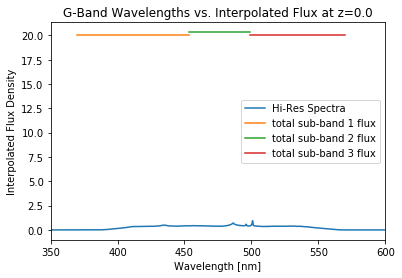

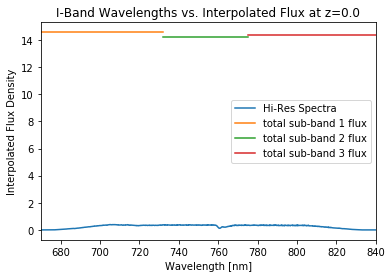

In [18]:
gInterp = np.interp(Wavelength, gWavelength, gThroughput)
# can now plot expected flux vs spectra for each band
fig, ax = plt.subplots(1,1)
ax.plot(Wavelength, FluxD*gInterp, label = 'Hi-Res Spectra')
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Interpolated Flux Density')
ax.set_title('G-Band Wavelengths vs. Interpolated Flux at z=0.0')
ax.plot(gsub1, [gflux1]*84, label='total sub-band 1 flux')
ax.plot(gsub2, [gflux2]*47, label='total sub-band 2 flux')
ax.plot(gsub3, [gflux3]*72, label='total sub-band 3 flux')
ax.set_xlim(350,600)
ax.legend(loc='best')
plt.show()

# i-band plot
fig, ax = plt.subplots(1,1)
ax.plot(Wavelength, FluxD*iInterp, label = 'Hi-Res Spectra')
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Interpolated Flux Density')
ax.set_title('I-Band Wavelengths vs. Interpolated Flux at z=0.0')
ax.plot(isub1, [iflux1]*63, label='total sub-band 1 flux')
ax.plot(isub2, [iflux2]*44, label='total sub-band 2 flux')
ax.plot(isub3, [iflux3]*66, label='total sub-band 3 flux')
ax.set_xlim(670,840)
ax.legend(loc='best')
plt.show()

# Part 3
## 3A

In [19]:
# Calculate effective wavelength for each band using throughputs as weighted average

gWeighted = np.average(gWavelength[0:7755], weights = gThroughput[0:7755])
print("Effective wavelength of the LSST g-band: {:.2f}.".format(gWeighted))
RgWeighted = calcRefrac(gWeighted, Ps, Pw, temperatureK, Zin)


iWeighted = np.average(iWavelength[0:7755], weights = iThroughput[0:7755])
print("Effective wavelength of the LSST i-band: {:.2f}.".format(iWeighted))
RiWeighted = calcRefrac(iWeighted, Ps, Pw, temperatureK, Zin)

Effective wavelength of the LSST g-band: 480.00 nm.
Effective wavelength of the LSST i-band: 754.22 nm.


## 3B

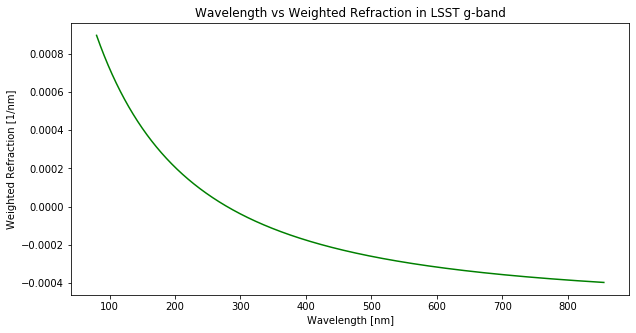

In [20]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
ax.plot(Wavelength, (R.value - RgWeighted.value), label='g-band', color='g')
ax.set_title('Wavelength vs Weighted Refraction in LSST g-band')
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Weighted Refraction [1/nm]')
plt.show()
### y-axis in (arcsec)
### should be R - R(@gWeighted)

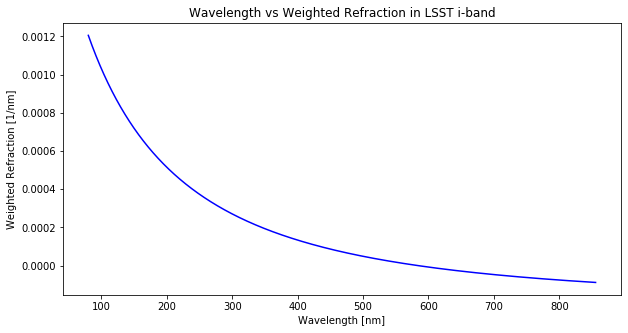

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
ax.plot(Wavelength, R.value - RiWeighted.value, label='i-band', color='b')
ax.set_title('Wavelength vs Weighted Refraction in LSST i-band')
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Weighted Refraction [1/nm]')
plt.show()